In [1]:
# Mount Google Drive if working on Colab

from google.colab import drive
drive.mount("/drive")

Mounted at /drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data = pd.read_csv("/drive/My Drive/car_price/cars_price.csv")
data.head(5)


,Unnamed: 0,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,0,honda,accord,565,1993,with mileage,960015.0,petrol,2000.0,black,mechanics,front-wheel drive,D
1,1,ford,fusion,5550,2008,with mileage,172000.0,diesel,1400.0,silver,mechanics,front-wheel drive,M
2,2,nissan,teana,8300,2008,with mileage,223000.0,petrol,2500.0,purple,auto,front-wheel drive,D
3,3,volkswagen,fox,3300,2005,with mileage,140000.0,petrol,1200.0,blue,mechanics,front-wheel drive,A
4,4,nissan,primera,2450,2002,with damage,413000.0,diesel,2200.0,burgundy,mechanics,front-wheel drive,D


In [9]:
data = data.iloc[:, 1:]

In [11]:
curr_time = datetime.datetime.now()
data['year'] = data['year'].apply(lambda x : curr_time.year - x)
data.head(5)

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,honda,accord,565,27,with mileage,960015.0,petrol,2000.0,black,mechanics,front-wheel drive,D
1,ford,fusion,5550,12,with mileage,172000.0,diesel,1400.0,silver,mechanics,front-wheel drive,M
2,nissan,teana,8300,12,with mileage,223000.0,petrol,2500.0,purple,auto,front-wheel drive,D
3,volkswagen,fox,3300,15,with mileage,140000.0,petrol,1200.0,blue,mechanics,front-wheel drive,A
4,nissan,primera,2450,18,with damage,413000.0,diesel,2200.0,burgundy,mechanics,front-wheel drive,D


In [52]:
data = data.drop(['model'],axis=1)

data['make'].value_counts()


volkswagen    4943
audi          2849
bmw           2839
opel          2662
renault       2650
              ... 
aro              1
tata             1
dong-feng        1
bogdan           1
jac              1
Name: make, Length: 93, dtype: int64

# **Data visualisation**

In [53]:
cars_numeric = data.select_dtypes(include =['int64','float64'])
cars_numeric.head()

,priceUSD,year,mileage(kilometers),volume(cm3)
0,565,27,960015.0,2000.0
1,5550,12,172000.0,1400.0
2,8300,12,223000.0,2500.0
3,3300,15,140000.0,1200.0
4,2450,18,413000.0,2200.0


<Figure size 2160x2160 with 0 Axes>

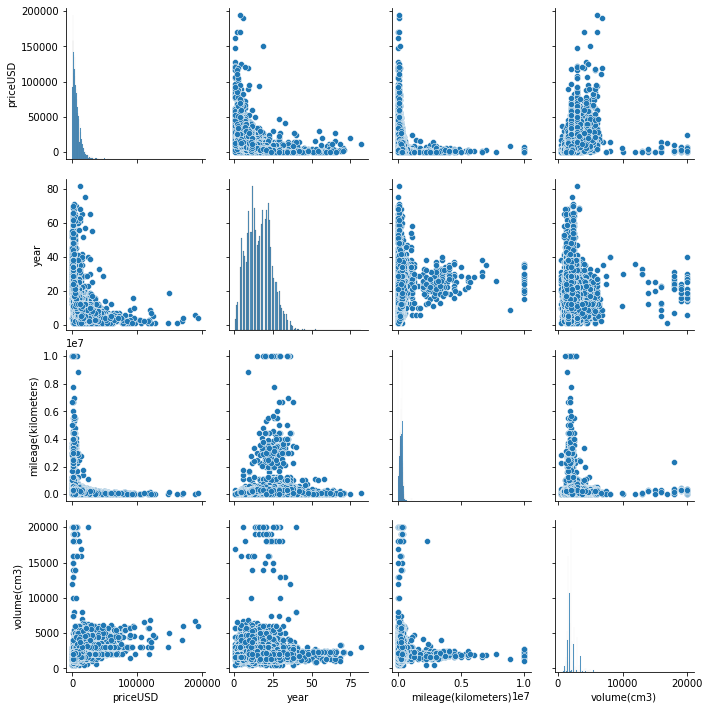

In [14]:
plt.figure(figsize = (30,30))
sns.pairplot(cars_numeric)
plt.show()

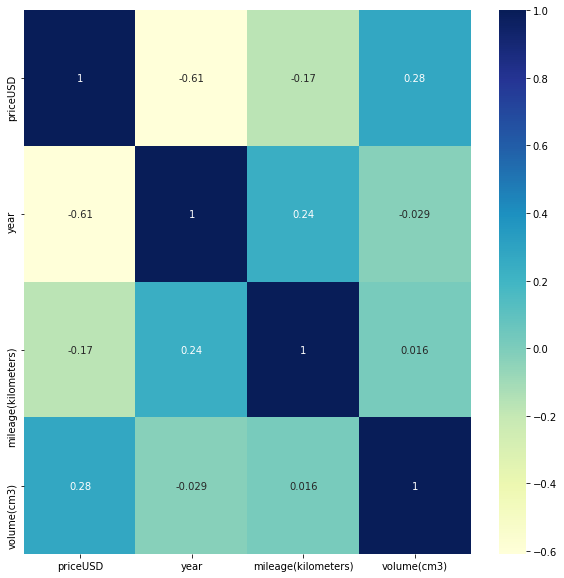

In [16]:
plt.figure(figsize = (10,10))
sns.heatmap(data.corr(), annot = True ,cmap = 'YlGnBu')
plt.show()

In [54]:
categorical_cols = data.select_dtypes(include = ['object'])
categorical_cols.head()

,make,condition,fuel_type,color,transmission,drive_unit,segment
0,honda,with mileage,petrol,black,mechanics,front-wheel drive,D
1,ford,with mileage,diesel,silver,mechanics,front-wheel drive,M
2,nissan,with mileage,petrol,purple,auto,front-wheel drive,D
3,volkswagen,with mileage,petrol,blue,mechanics,front-wheel drive,A
4,nissan,with damage,diesel,burgundy,mechanics,front-wheel drive,D


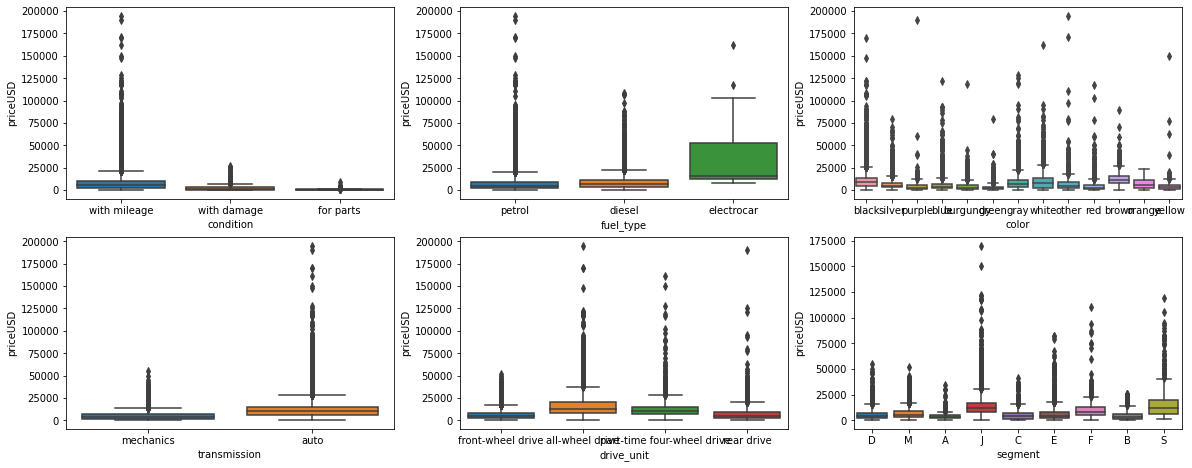

In [18]:

plt.figure(figsize = (20,12))
plt.subplot(3,3,1)
sns.boxplot(x = 'condition', y = 'priceUSD', data = data)
plt.subplot(3,3,2)
sns.boxplot(x = 'fuel_type', y = 'priceUSD', data = data)
plt.subplot(3,3,3)
sns.boxplot(x = 'color', y = 'priceUSD', data = data)
plt.subplot(3,3,4)
sns.boxplot(x = 'transmission', y = 'priceUSD', data = data)
plt.subplot(3,3,5)
sns.boxplot(x = 'drive_unit', y = 'priceUSD', data = data)
plt.subplot(3,3,6)
sns.boxplot(x = 'segment', y = 'priceUSD', data = data)

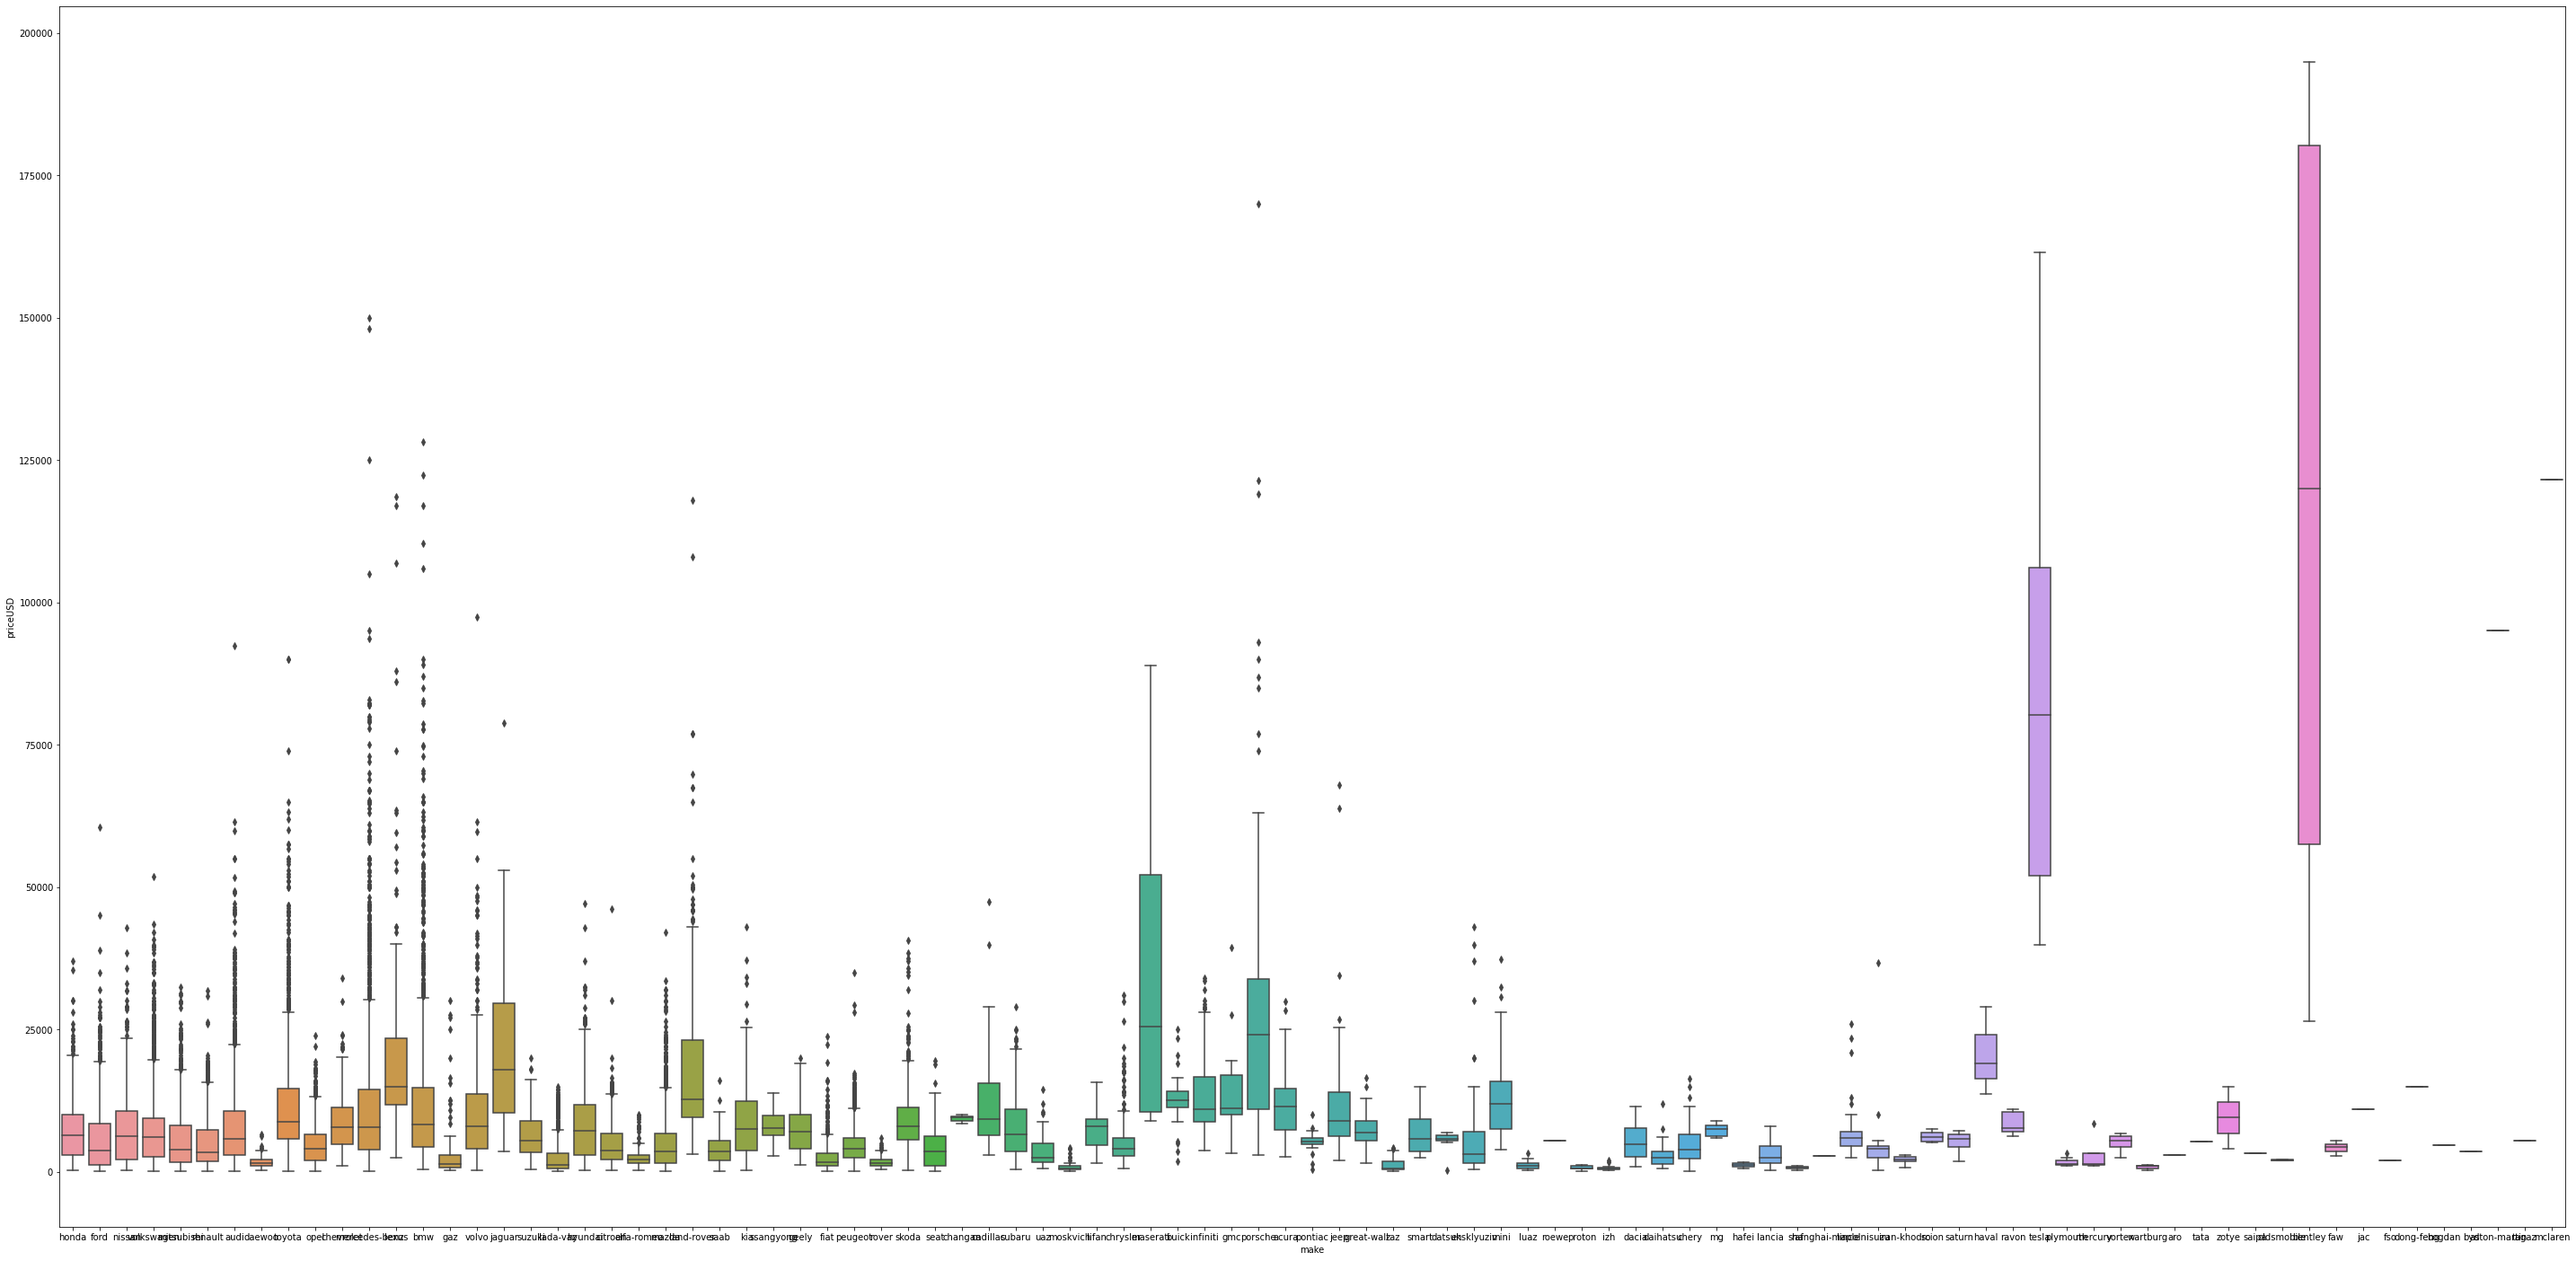

In [22]:
plt.figure(figsize = (50,25))
sns.boxplot(x = 'make', y = 'priceUSD', data = data)

# **Data preparation**

In [55]:
#creating dummies
cars_dummies = pd.get_dummies(categorical_cols, drop_first = True)
cars_dummies.head()

,make_alfa-romeo,make_aro,make_aston-martin,make_audi,make_bentley,make_bmw,make_bogdan,make_buick,make_byd,make_cadillac,make_changan,make_chery,make_chevrolet,make_chrysler,make_citroen,make_dacia,make_daewoo,make_daihatsu,make_datsun,make_dong-feng,make_eksklyuziv,make_faw,make_fiat,make_ford,make_fso,make_gaz,make_geely,make_gmc,make_great-wall,make_hafei,make_haval,make_honda,make_hyundai,make_infiniti,make_iran-khodro,make_isuzu,make_izh,make_jac,make_jaguar,make_jeep,...,make_suzuki,make_tagaz,make_tata,make_tesla,make_toyota,make_uaz,make_volkswagen,make_volvo,make_vortex,make_wartburg,make_zaz,make_zotye,condition_with damage,condition_with mileage,fuel_type_electrocar,fuel_type_petrol,color_blue,color_brown,color_burgundy,color_gray,color_green,color_orange,color_other,color_purple,color_red,color_silver,color_white,color_yellow,transmission_mechanics,drive_unit_front-wheel drive,drive_unit_part-time four-wheel drive,drive_unit_rear drive,segment_B,segment_C,segment_D,segment_E,segment_F,segment_J,segment_M,segment_S
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0


In [56]:
car_df  = pd.concat([data, cars_dummies], axis =1)

In [57]:
categorical_cols.columns

Index(['make', 'condition', 'fuel_type', 'color', 'transmission', 'drive_unit',
       'segment'],
      dtype='object')

In [58]:
car_df = car_df.drop(['make', 'condition', 'fuel_type', 'color', 'transmission',
       'drive_unit', 'segment'], axis =1)

In [59]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 124 entries, priceUSD to segment_S
dtypes: float64(2), int64(2), uint8(120)
memory usage: 5.8 MB


In [60]:
cars_numeric.columns

Index(['priceUSD', 'year', 'mileage(kilometers)', 'volume(cm3)'], dtype='object')

In [61]:
col_list = ['priceUSD', 'year', 'mileage(kilometers)', 'volume(cm3)']

In [62]:
for column in car_df[col_list]:
    car_df[column] = car_df[column].fillna(car_df[column].mean())
car_df.isna().sum().sum()

0

In [63]:
#train[col_list] = scaler.fit_transform(train[col_list])
scaler = StandardScaler()
test = car_df['priceUSD']
#test = car_df['priceUSD']
train = car_df.drop(["priceUSD"],axis=1)
train = scaler.fit_transform(train)
#test = test.values.reshape(-1,1)
#test = scaler.transform(pd.DataFrame(test))

In [64]:
#df_train, df_test = train_test_split(car_df, train_size = 0.7, test_size = 0.3, random_state = 100)
X_train, X_test, y_train, y_test = train_test_split(train, test, train_size=0.7, test_size = 0.3, random_state=100)

# **model**

In [65]:
lin_model = LinearRegression()

lin_model.fit(X_train, y_train)

lin_y_preds = lin_model.predict(X_test)

In [66]:
lgb_model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    n_estimators=100,
    reg_lambda=1.0
)

lgb_model.fit(X_train, y_train)

lgb_y_preds = lgb_model.predict(X_test)

In [67]:
lin_loss = np.sqrt(mean_squared_error(y_test, lin_y_preds))
lgb_loss = np.sqrt(mean_squared_error(y_test, lgb_y_preds))

In [68]:
print("Linear Regression RMSE:", lin_loss)
print("Gradient Boosted RMSE:", lgb_loss)

Linear Regression RMSE: 9.487863061090789e+16
Gradient Boosted RMSE: 3393.817072645066


In [69]:
print("Linear Regression R^2 Score:", lin_model.score(X_test, y_test))

print("Gradient Boosted R^2 Score:", lgb_model.score(X_test, y_test))

Linear Regression R^2 Score: -1.3187032599517196e+26
Gradient Boosted R^2 Score: 0.8312720133982154


# **madel building using RFE**

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)

# Subsetting training data for 15 selected columns
rfe = RFE(lr,15)
rfe.fit(X_train, y_train)

In [ ]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

In [ ]:
cols = X_train.columns[rfe.support_]
cols

# **mode1**

In [ ]:
X1 = X_train[cols]
X1_sm = sm.add_constant(X1)

lr_1 = sm.OLS(y_train,X1_sm).fit()

In [ ]:
print(lr_1.summary())

In [ ]:
#VIF
vif = pd.DataFrame()
vif['Features'] = X1.columns
vif['VIF'] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

# **building model with 10 variable**

In [ ]:
lr2 = LinearRegression()

rfe2 = RFE(lr2,10)
rfe2.fit(X_train,y_train)

In [ ]:
list(zip(X_train.columns,rfe2.support_,rfe2.ranking_))

In [ ]:
supported_cols = X_train.columns[rfe2.support_]
supported_cols

# **model2**

In [ ]:
X2 = X_train[supported_cols]
X2_sm = sm.add_constant(X2)

model_2 = sm.OLS(y_train,X2_sm).fit()

In [ ]:
print(model_2.summary())

In [ ]:
#VIF
vif = pd.DataFrame()
vif['Features'] = X2.columns
vif['VIF'] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif